In [104]:
# prelude 

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures   
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score  

k_target        = "converted"
k_test_size     = 20/100    # see train_test_split
k_random_state  = 42        # you know why this value...
k_header        = "conversion_data_test_predictions_"
k_author        = "PHILIPPE"


# Conversion Rate Challenge : Baseline model

* The code below :  
  * Trains a baseline model on the dataset 
  * At this stage the model is a ``LogisticRegression()`` 
  * Optionally `PolynomialFeatures()` can be activated. This is not currently the case (indeed `poly__degree` is set to 1)
  * It records predictions made on the unlabeled observations
* Different models have been tested and predictions sent to the leaderboard

In [105]:
df = pd.read_csv("./assets/conversion_data_train.csv")

#######################################################################
# training on train and test set
X = df.drop(columns = k_target)
y = df[k_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state, stratify = y)

numeric_features      = X.select_dtypes(include="number").columns
categorical_features  = X.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(
  steps=[
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    # drop first has no impact on the scores
    # However when using drop first it is then harder to find and communicate about features importance
    # Indeed one of each categorical feature is missing 
    # ("encoder_cat", OneHotEncoder(drop="first")),                 
    ("encoder_cat", OneHotEncoder()),                 
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer,     numeric_features),
    ("cat", categorical_transformer, categorical_features),
  ]
)

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures()),
    ("logistic", LogisticRegression())
])

# Generate warnings at runtime
# params = {
#     "poly__degree"    : [1],
#     "logit__C"        : [3, 0.1],
#     "logit__penalty"  : ["none", "l2"],
# }

# Do NOT generate warnings at runtime AND features importance works like a charm (see include_bias below)
# Conditional search grid
#   Two parameter dictionaries are defined in the params list. 
#       One uses the “l2” penalty with different C values
#       The other disables the penalty with penalty=None.
params = [
    {
        "poly__degree": [1],
        "poly__include_bias":[False],
        "logistic__C": [3, 0.1],
        "logistic__penalty": ["l2"],  # Utiliser `l2` pour la régularisation
    },
    {
        "poly__degree": [1],
        "poly__include_bias":[False],
        "logistic__penalty": [None],  # None instead of none otherwise warning
    },
]


gridsearch = GridSearchCV(pipe, param_grid = params, cv = 3, scoring="f1", n_jobs = -1)
gridsearch.fit(X_train, y_train)

best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X_test)

print(f"Best results on test dataset               :")
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y_test,  y_pred):.6f} \t {precision_score(y_test,  y_pred):.6f} \t {recall_score(y_test,  y_pred):.6f}")

#######################################################################
# Training on the whole dataset
X = df.drop(columns = k_target)
y = df[k_target]

X = preprocessor.fit_transform(X) # X is now an ndarray

gridsearch.fit(X, y)
best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X)

print()
print(f"Best results on whole dataset (train+test) :")
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred):.6f} \t {precision_score(y,  y_pred):.6f} \t {recall_score(y,  y_pred):.6f}")

#######################################################################
# Prediction on unlabeled dataset
X_no_labels = pd.read_csv("./assets/conversion_data_test.csv")
X_no_labels = preprocessor.transform(X_no_labels)

data = {
  "converted": best_estimator.predict(X_no_labels)
}

y_predictions = pd.DataFrame(columns=["converted"], data=data)

trailer   = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file  = "./assets/" + k_header + k_author + "-" + trailer + ".csv"
y_predictions.to_csv(out_file, index=False)

Best results on test dataset               :
f1 		 precision 	 recall
0.768252 	 0.865529 	 0.690632

Best results on whole dataset (train+test) :
f1 		 precision 	 recall
0.763880 	 0.855176 	 0.690196


### <span style="color:orange"><b>Comments :</b></span>

* The most interesting part in the code above is the one close to ``GrideSearchCV()`` where :
    * We define a pipe 
    * For each element of the pipe we define parameter values or range of values
        * If `poly__degree` is set to 1, everything happens as if there were no feature engineering and the ``LogisticRegression`` is used on the initial features
* With this dataset, early results show that a simple ``LogisticRegression`` was <span style="color:orange"><b>"good enough"</b></span>
* Other than that we were spending time to fine tune parameters in order to increase the F1 score at the fourth decimal
    * Does it make sense? No !
* Unfortunately, the code above does not help to compare different models (XGBoost vs LogisticeRegression vs XYZ model with a,b and c hyperparameters)

It was at this stage of the Conversion Rate Challenge that the idea of a <span style="color:orange"><b>framework</b></span> of some kind came up...

## Performance analysis

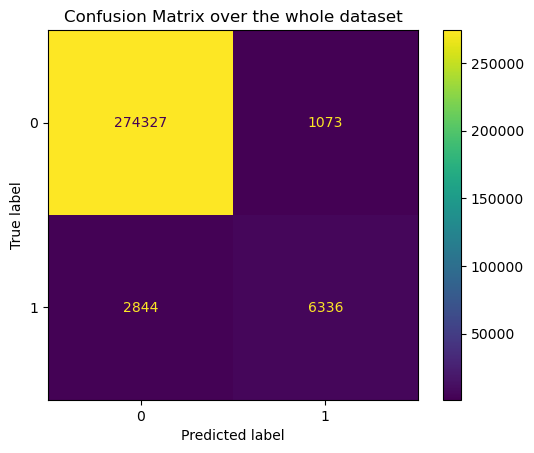

In [106]:

_, ax = plt.subplots()  
ax.set(
    title="Confusion Matrix over the whole dataset"
)  
ConfusionMatrixDisplay.from_estimator(
    best_estimator, X, y, ax=ax
)  
plt.show()


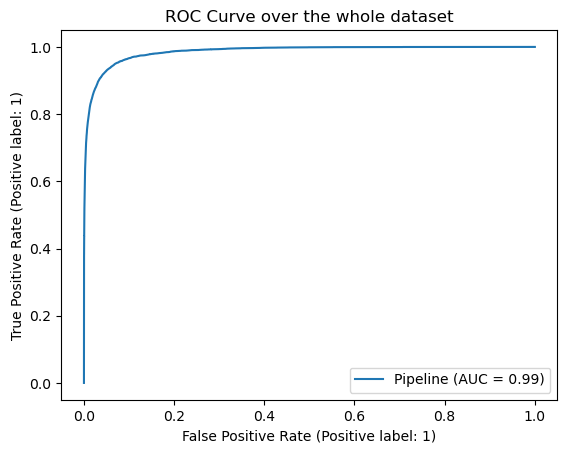

In [107]:
_, ax = plt.subplots()  
ax.set(
    title="ROC Curve over the whole dataset"
)  
RocCurveDisplay.from_estimator(
    best_estimator, X, y, ax=ax
)  
plt.show()


In [108]:
auc = roc_auc_score(y, y_pred)
print(f"AUC: {auc:.2f}")

AUC: 0.84


## Features Importance

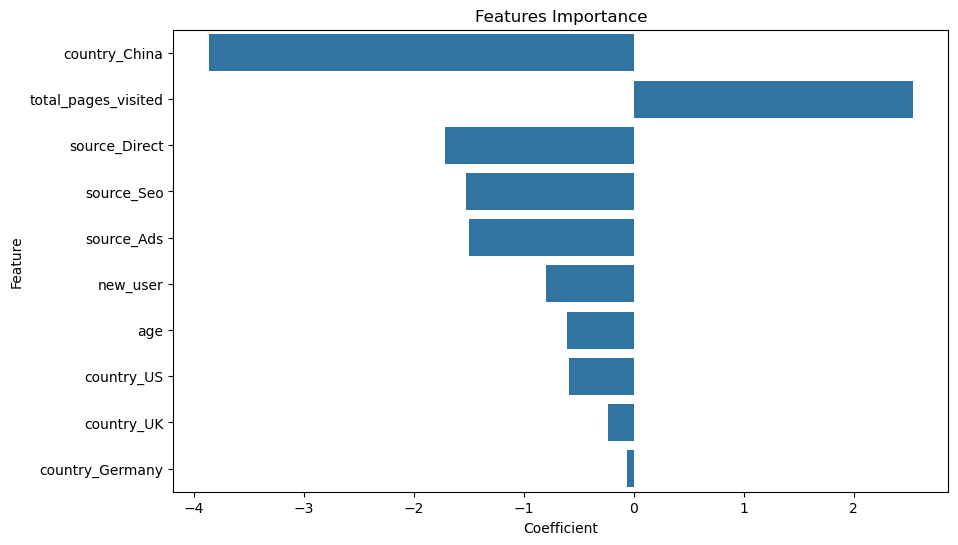

In [109]:
# find the LogisticRegression within the pipe
logistic_model = best_estimator.named_steps["logistic"]  

# Get num feature names 
num_features_names = numeric_features

# Get category feature names (Z! OneHotEncoder())
cat_transformer = preprocessor.named_transformers_['cat']['encoder_cat']
categorical_features_names = cat_transformer.get_feature_names_out(categorical_features)

# Stack arrays in sequence horizontally (column wise)
all_feature_names = np.hstack([num_features_names, categorical_features_names])

# find the coefs from the model
coefficients = logistic_model.coef_[0]

features_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

features_df = features_df.reindex(features_df["Coefficient"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=features_df)
plt.title("Features Importance")
plt.show()

### <span style="color:orange"><b>Comments :</b></span>

* A positive coefficient indicates that increasing this feature increases the probability that the observation will be classified in the positive class 
* A negative coefficient indicates that increasing this feature decreases the probability of belonging to the positive class
* **Recommendation :** may be we should have a news letter in Chineese

## Adjusting the treshold of the Logistic Regression

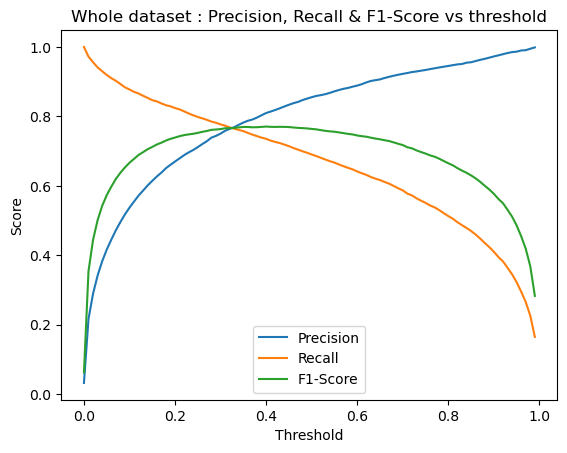

F1 score max value : 0.770680
Optimal threshold  : 0.4


In [110]:
def predict_with_threshold(probs, threshold):
    return (probs >= threshold).astype(int)


# Define a range of thresholds 
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []
f1_scores = []

# Predict probabilities for the positive class (1)
y_prob = best_estimator.predict_proba(X)[:, 1]
for threshold in thresholds:
    y_pred = predict_with_threshold(y_prob, threshold)
    precisions.append(precision_score(y, y_pred))
    recalls.append(recall_score(y, y_pred))
    f1_scores.append(f1_score(y, y_pred))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Whole dataset : Precision, Recall & F1-Score vs threshold")
plt.show()

print(f"F1 score max value : {max(f1_scores):.6f}")
max_index = f1_scores.index(max(f1_scores))
print(f"Optimal threshold  : {thresholds[max_index]}")

### <span style="color:orange"><b>Comments :</b></span>

* The previous value of F1 score was 0.763880
* The new value of the F1 score is increased only by +0.9%

## How to use the threshold ?

In [111]:
# Training on the whole dataset
X = df.drop(columns = k_target)
y = df[k_target]

X = preprocessor.fit_transform(X) # X is now an ndarray

gridsearch.fit(X, y)
best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X)

y_prob = best_estimator.predict_proba(X)[:, 1]
threshold = 0.4                                      # ! HARDCODED :-(
y_pred_custom = (y_prob >= threshold).astype(int)

print()
print(f"Best results on whole dataset (train+test) :")
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred_custom):.6f} \t {precision_score(y,  y_pred_custom):.6f} \t {recall_score(y,  y_pred_custom):.6f}")



Best results on whole dataset (train+test) :
f1 		 precision 	 recall
0.770680 	 0.809644 	 0.735294


### <span style="color:orange"><b>Comments :</b></span>

* Obviously we find the same F1 score 0.770680 


## Using the treshold on the unlabeled dataset

In [112]:
X_no_labels = pd.read_csv("./assets/conversion_data_test.csv")
X_no_labels = preprocessor.transform(X_no_labels)

y_pred = best_estimator.predict(X_no_labels)
y_prob = best_estimator.predict_proba(X_no_labels)[:, 1]
threshold = 0.4                                      # ! HARDCODED :-(
y_pred_custom = (y_prob >= threshold).astype(int)

data = {
  "converted": y_pred_custom
}

y_predictions = pd.DataFrame(columns=["converted"], data=data)

trailer   = datetime.now().strftime("%Y%m%d_%H%M%S")
out_file  = "./assets/" + k_header + k_author + "-" + trailer + "-treshold.csv"
y_predictions.to_csv(out_file, index=False)

### <span style="color:orange"><b>Comments :</b></span>

* One can open both predictions CSV files on unlabeled data
* We can see that only 97 predictions are different
* Since there are 31_620 predictions this represent 0.3% 
* With a lower threshold (0.4 vs 0.5 by default) the differences always happen when the "tresholded" prediction is now 1 while it used to be 0 

<p align="center">
<img src="./assets/threshold_differences.png" alt="drawing" width="600"/>
</p>

# SCRAP Book - Please ignore

In [76]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures   

k_target        = "converted"
k_test_size     = 20/100    
k_random_state  = 42

data = {
    'country': ['China', 'UK', 'Germany', 'US', 'US'],
    'age': [22, 21, 20, 23, 28],
    'new_user': [1, 1, 0, 1, 1],
    'source': ['Direct', 'Ads', 'Seo', 'Seo', 'Direct'],
    'total_pages_visited': [2, 3, 14, 3, 3],
    'converted': [0, 0, 1, 0, 0]
}

df = pd.DataFrame(data)
print(df.head(), "\n")

X = df.drop(columns = k_target)
print(X.head(), "\n")
y = df[k_target]

numeric_features      = X.select_dtypes(include="number").columns
categorical_features  = X.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(
  steps=[
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
      ("encoder_cat", OneHotEncoder()),                 
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer,     numeric_features),
    ("cat", categorical_transformer, categorical_features),
  ]
)

X = preprocessor.fit_transform(X)
np.set_printoptions(precision=2)
print (X, "\n")
np.set_printoptions(precision=8) # defaut voir doc



numeric_features_names = numeric_features.tolist()
cat_transformer = preprocessor.named_transformers_['cat']['encoder_cat']
categorical_features_names = cat_transformer.get_feature_names_out(categorical_features)
all_feature_names = np.hstack([numeric_features_names, categorical_features_names])
print(all_feature_names)

   country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0 

   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3 

[[-0.29  0.5  -0.66  1.    0.    0.    0.    0.    1.    0.  ]
 [-0.65  0.5  -0.44  0.    0.    1.    0.    1.    0.    0.  ]
 [-1.01 -2.    1.99  0.    1.    0.    0.    0.    0.    1.  ]
 [ 0.07  0.5  -0.44  0.    0.    0.    1.    0.    0.    1.  ]
 [ 1.87  0.5  -0.4

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures   
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score  

k_target        = "converted"
k_test_size     = 20/100    # see train_test_split
k_random_state  = 42        # you know why this value...
k_header        = "conversion_data_test_predictions_"
k_author        = "PHILIPPE"


df = pd.read_csv("./assets/conversion_data_train.csv")

X = df.drop(columns = k_target)
y = df[k_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state, stratify = y)

numeric_features      = X.select_dtypes(include="number").columns
categorical_features  = X.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(
  steps=[
    ("scaler_num", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    ("encoder_cat", OneHotEncoder()),                 
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer,     numeric_features),
    ("cat", categorical_transformer, categorical_features),
  ]
)

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

pipe = Pipeline(steps=[
    ("poly", PolynomialFeatures()),
    ("logistic", LogisticRegression())
])

params = [
    {
        "poly__degree": [1],
        "poly__include_bias":[False],
        "logistic__C": [3, 0.1],
        "logistic__penalty": ["l2"],  # Utiliser `l2` pour la régularisation
    },
    {
        "poly__degree": [1],
        "poly__include_bias":[False],
        "logistic__penalty": [None],  # None instead of none otherwise warning
    },
]


gridsearch = GridSearchCV(pipe, param_grid = params, cv = 3, scoring="f1", n_jobs = -1)
gridsearch.fit(X_train, y_train)

best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X_test)

print(f"Best results on test dataset               :")
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y_test,  y_pred):.6f} \t {precision_score(y_test,  y_pred):.6f} \t {recall_score(y_test,  y_pred):.6f}")

#######################################################################
# Training on the whole dataset
X = df.drop(columns = k_target)
y = df[k_target]

X = preprocessor.fit_transform(X) # X is now an ndarray

gridsearch.fit(X, y)
best_estimator = gridsearch.best_estimator_
y_pred = best_estimator.predict(X)

print()
print(f"Best results on whole dataset (train+test) :")
print(f"f1 \t\t precision \t recall")
print(f"{f1_score(y,  y_pred):.6f} \t {precision_score(y,  y_pred):.6f} \t {recall_score(y,  y_pred):.6f}")


# find the LogisticRegression within the pipe
logistic_model = best_estimator.named_steps["logistic"]  

# Get num feature names 
num_features_names = numeric_features
print("\nnum features:\n", num_features_names)

# Get category feature names (Z! OneHotEncoder())
cat_transformer = preprocessor.named_transformers_['cat']['encoder_cat']
categorical_features_names = cat_transformer.get_feature_names_out(categorical_features)
print("\ncat features:\n", categorical_features_names)

# Stack arrays in sequence horizontally (column wise)
all_feature_names = np.hstack([num_features_names, categorical_features_names])
print("\nall features:\n", all_feature_names)

# find the coefs from the model
coefficients = logistic_model.coef_[0]
print("\ncoefs:\n", coefficients)

features_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

# sort according magnitude of the abs() BUT keep the sign of the coefs
features_df = features_df.reindex(features_df["Coefficient"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=features_df)
plt.title("Features Importance")
plt.show()


In [79]:
def predict_with_threshold(probs, threshold):
    return (probs >= threshold).astype(int)


y_prob = best_estimator.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = predict_with_threshold(y_prob, threshold)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Seuil: {threshold}")
print(f"Précision: {precision:.2f}")
print(f"Rappel: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Seuil: 0.3
Précision: 0.75
Rappel: 0.78
F1-Score: 0.77


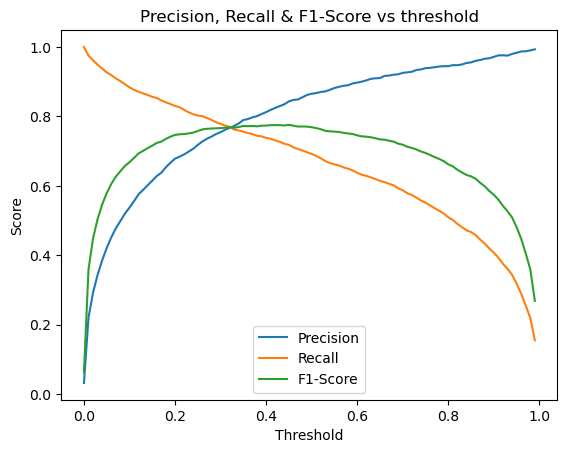

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Gamme de seuils à tester
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred = predict_with_threshold(y_prob, threshold)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Tracer les métriques en fonction du seuil
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall & F1-Score vs threshold")
plt.show()

In [86]:
print(max(f1_scores))
max_index = f1_scores.index(max(f1_scores))
print(thresholds[max_index])

0.7755222124154163
0.45
